## The code is borrowed from the following link
- [Original Code](https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb)

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [139]:
import collections
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Dataset
The dataset is located at **data** folder. The \"small_vocab_en\" contains English senteces and the "small_vocab_fr" contains the corresponding French translation. 

In [140]:
import os
def load_data(path):
    data_file = os.path.join(path)
    with open(data_file,"r") as f:
        lang_data = f.read()
    return lang_data.split('\n')


In [141]:
# Load English data
english_sentences = load_data('../data/small_vocab_en.txt')
# Load French data
french_sentences = load_data('../data/small_vocab_fr.txt')
print('Dataset Loaded')

Dataset Loaded


### Visualize data
Each line in small_vocab_en contains an English sentence with the respective translation in each line of small_vocab_fr. View the first two lines from each file.

In [142]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary. A more complex vocabulary is a more complex problem. Let's look at the complexity of the dataset we'll be working with.

In [143]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:

Tokenize the words into ids
Add padding to make all the sequences the same length.
Time to start preprocessing the data...

#### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings. Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number. These are called character and word ids, respectively. Character ids are used for character level models that generate text predictions for each character. A word level model uses word ids that generate text predictions for each word. Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's Tokenizer function. Use this function to tokenize english_sentences and french_sentences in the cell below.

Running the cell will run tokenize on sample data and show output for debugging.

In [144]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # TODO: Implement
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)  
When batching the sequence of word ids together, each sequence needs to be the same length. Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the end of each sequence using Keras's pad_sequences function.

In [145]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline. Instead, we've provided you with the implementation of the preprocess function.

In [146]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)+1

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want. We want the French translation. The function logits_to_text will bridge the gab between the logits from the neural network to the French translation. You'll be using this function to better understand the output of the neural network.

In [147]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


++++++++++++++++++++++++++

In [148]:
# === Cell 1: Imports + data config + hyperparameters ===
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import (Input, Embedding, SimpleRNN, LSTM, GRU,
                                     RepeatVector, TimeDistributed, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

# Use the arrays produced by the professor's preprocessing
X = preproc_english_sentences.astype("int32")      # (N, T_en)
Y = preproc_french_sentences.astype("int32")       # (N, T_fr, 1)
T_en = int(max_english_sequence_length)
T_fr = int(max_french_sequence_length)

# Embedding/output-safe vocabulary sizes (covers PAD=0 and the largest id)
emb_en_vocab = int(X.max()) + 1
emb_fr_vocab = int(Y.max()) + 1

# Shared hyperparameters (identical across models for fairness)
EMBED_DIM   = 128
UNITS       = 256
ENC_LAYERS  = 2
DEC_LAYERS  = 2
DROPOUT     = 0.2
REC_DROPOUT = 0.0   # GPU/CuDNN speed; recurrent dropout off
BATCH_SIZE  = 128
EPOCHS      = 20
VAL_SPLIT   = 0.10

print({
    "X": X.shape, "Y": Y.shape, "T_en": T_en, "T_fr": T_fr,
    "emb_en_vocab": emb_en_vocab, "emb_fr_vocab": emb_fr_vocab
})


{'X': (137861, 15), 'Y': (137861, 21, 1), 'T_en': 15, 'T_fr': 21, 'emb_en_vocab': 200, 'emb_fr_vocab': 345}


In [149]:
# === Cell 2: Builders — 2-layer SimpleRNN / LSTM / GRU encoder–decoder ===
def build_seq2seq_simple_rnn():
    inp = Input(shape=(T_en,), name="enc_input")
    x = Embedding(emb_en_vocab, EMBED_DIM, mask_zero=True, name="src_embed")(inp)
    # Encoder (2 layers)
    x = SimpleRNN(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_rnn_1")(x)
    x = SimpleRNN(UNITS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_rnn_2")(x)
    # Bridge
    x = RepeatVector(T_fr, name="bridge_repeat")(x)
    # Decoder (2 layers)
    x = SimpleRNN(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_rnn_1")(x)
    x = SimpleRNN(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_rnn_2")(x)
    # Output
    out = TimeDistributed(Dense(emb_fr_vocab, activation="softmax"), name="output_softmax")(x)
    model = Model(inp, out, name="Seq2Seq_2xSimpleRNN")
    model.compile(optimizer=Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=[SparseCategoricalAccuracy(name="accuracy")])  # prints accuracy/val_accuracy
    return model

def build_seq2seq_lstm():
    inp = Input(shape=(T_en,), name="enc_input")
    x = Embedding(emb_en_vocab, EMBED_DIM, mask_zero=True, name="src_embed")(inp)
    x = LSTM(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_lstm_1")(x)
    x = LSTM(UNITS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_lstm_2")(x)
    x = RepeatVector(T_fr, name="bridge_repeat")(x)
    x = LSTM(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_lstm_1")(x)
    x = LSTM(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_lstm_2")(x)
    out = TimeDistributed(Dense(emb_fr_vocab, activation="softmax"), name="output_softmax")(x)
    model = Model(inp, out, name="Seq2Seq_2xLSTM")
    model.compile(optimizer=Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=[SparseCategoricalAccuracy(name="accuracy")])
    return model

def build_seq2seq_gru():
    inp = Input(shape=(T_en,), name="enc_input")
    x = Embedding(emb_en_vocab, EMBED_DIM, mask_zero=True, name="src_embed")(inp)
    x = GRU(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_gru_1")(x)
    x = GRU(UNITS, return_sequences=False, dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="enc_gru_2")(x)
    x = RepeatVector(T_fr, name="bridge_repeat")(x)
    x = GRU(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_gru_1")(x)
    x = GRU(UNITS, return_sequences=True,  dropout=DROPOUT, recurrent_dropout=REC_DROPOUT, name="dec_gru_2")(x)
    out = TimeDistributed(Dense(emb_fr_vocab, activation="softmax"), name="output_softmax")(x)
    model = Model(inp, out, name="Seq2Seq_2xGRU")
    model.compile(optimizer=Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=[SparseCategoricalAccuracy(name="accuracy")])
    return model


In [150]:
# === Cell 3: Instantiate models + summaries ===
rnn_model  = build_seq2seq_simple_rnn()
lstm_model = build_seq2seq_lstm()
gru_model  = build_seq2seq_gru()

rnn_model.summary(line_length=120)
lstm_model.summary(line_length=120)
gru_model.summary(line_length=120)


Model: "Seq2Seq_2xSimpleRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ enc_input (InputLayer)            │ (None, 15)                   │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ src_embed (Embedding)             │ (None, 15, 128)              │            25,600 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ not_equal_21 (NotEqual)           │ (None, 15)                   │                 0 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_rnn_1 (SimpleRNN)             │ (None, 15, 256)              │            98,560 │ src_embed[0][0],          
│                                   │                              │                   │ not_equal_21[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_rnn_2 (SimpleRNN)             │ (None, 256)                  │           131,328 │ enc_rnn_1[0][0],          
│                                   │                              │                   │ not_equal_21[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bridge_repeat (RepeatVector)      │ (None, 21, 256)              │                 0 │ enc_rnn_2[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_rnn_1 (SimpleRNN)             │ (None, 21, 256)              │           131,328 │ bridge_repeat[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_rnn_2 (SimpleRNN)             │ (None, 21, 256)              │           131,328 │ dec_rnn_1[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_softmax (TimeDistributed)  │ (None, 21, 345)              │            88,665 │ dec_rnn_2[0][0]           
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 606,809 (2.31 MB)

 Trainable params: 606,809 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Seq2Seq_2xLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ enc_input (InputLayer)            │ (None, 15)                   │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ src_embed (Embedding)             │ (None, 15, 128)              │            25,600 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ not_equal_22 (NotEqual)           │ (None, 15)                   │                 0 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_lstm_1 (LSTM)                 │ (None, 15, 256)              │           394,240 │ src_embed[0][0],          
│                                   │                              │                   │ not_equal_22[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_lstm_2 (LSTM)                 │ (None, 256)                  │           525,312 │ enc_lstm_1[0][0],         
│                                   │                              │                   │ not_equal_22[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bridge_repeat (RepeatVector)      │ (None, 21, 256)              │                 0 │ enc_lstm_2[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_lstm_1 (LSTM)                 │ (None, 21, 256)              │           525,312 │ bridge_repeat[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_lstm_2 (LSTM)                 │ (None, 21, 256)              │           525,312 │ dec_lstm_1[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_softmax (TimeDistributed)  │ (None, 21, 345)              │            88,665 │ dec_lstm_2[0][0]          
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 2,084,441 (7.95 MB)

 Trainable params: 2,084,441 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Seq2Seq_2xGRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ enc_input (InputLayer)            │ (None, 15)                   │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ src_embed (Embedding)             │ (None, 15, 128)              │            25,600 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ not_equal_23 (NotEqual)           │ (None, 15)                   │                 0 │ enc_input[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_gru_1 (GRU)                   │ (None, 15, 256)              │           296,448 │ src_embed[0][0],          
│                                   │                              │                   │ not_equal_23[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ enc_gru_2 (GRU)                   │ (None, 256)                  │           394,752 │ enc_gru_1[0][0],          
│                                   │                              │                   │ not_equal_23[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bridge_repeat (RepeatVector)      │ (None, 21, 256)              │                 0 │ enc_gru_2[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_gru_1 (GRU)                   │ (None, 21, 256)              │           394,752 │ bridge_repeat[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dec_gru_2 (GRU)                   │ (None, 21, 256)              │           394,752 │ dec_gru_1[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ output_softmax (TimeDistributed)  │ (None, 21, 345)              │            88,665 │ dec_gru_2[0][0]           
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 1,594,969 (6.08 MB)

 Trainable params: 1,594,969 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# === Cell 4: Callbacks (EarlyStopping, LR scheduler) + per-epoch timer ===
class EpochTimer(Callback):
    def on_train_begin(self, logs=None): self.times=[]
    def on_epoch_begin(self, epoch, logs=None): import time; self._t0=time.time()
    def on_epoch_end(self, epoch, logs=None):
        import time; self.times.append(time.time()-self._t0)

def make_cbs():
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    ]

history, times = {}, {}


In [153]:
# === Cell 5: Train — 2x SimpleRNN (prints loss, accuracy, val_loss, val_accuracy each epoch) ===
timer_rnn = EpochTimer()
hist_rnn = rnn_model.fit(
    X, Y,
    validation_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    callbacks=make_cbs() + [timer_rnn]
)
history['rnn'] = hist_rnn.history
times['rnn']   = timer_rnn.times


Epoch 1/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 127s 130ms/step - accuracy: 0.6534 - loss: 1.3192 - val_accuracy: 0.6914 - val_loss: 1.0730 - learning_rate: 0.0010
Epoch 2/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 114s 118ms/step - accuracy: 0.7379 - loss: 0.8805 - val_accuracy: 0.7789 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 3/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 131s 135ms/step - accuracy: 0.7688 - loss: 0.7475 - val_accuracy: 0.7976 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch 4/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 134s 138ms/step - accuracy: 0.7939 - loss: 0.6408 - val_accuracy: 0.8246 - val_loss: 0.5346 - learning_rate: 0.0010
Epoch 5/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 131s 135ms/step - accuracy: 0.8164 - loss: 0.5644 - val_accuracy: 0.8508 - val_loss: 0.4562 - learning_rate: 0.0010
Epoch 6/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 139s 143ms/step - accuracy: 0.8302 - loss: 0.5159 - val_accuracy: 0.8638 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 7/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 160s 165ms/step - accura

In [ ]:
# === Cell 6: Train — 2x LSTM ===
timer_lstm = EpochTimer()
hist_lstm = lstm_model.fit(
    X, Y,
    validation_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    callbacks=make_cbs() + [timer_lstm]
)
history['lstm'] = hist_lstm.history
times['lstm']   = timer_lstm.times


Epoch 1/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 312s 315ms/step - accuracy: 0.5795 - loss: 1.7329 - val_accuracy: 0.6754 - val_loss: 1.1404 - learning_rate: 0.0010
Epoch 2/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 283s 291ms/step - accuracy: 0.7032 - loss: 1.0016 - val_accuracy: 0.7292 - val_loss: 0.8691 - learning_rate: 0.0010
Epoch 3/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 414s 427ms/step - accuracy: 0.7393 - loss: 0.8289 - val_accuracy: 0.7588 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 4/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 402s 415ms/step - accuracy: 0.7662 - loss: 0.7106 - val_accuracy: 0.7934 - val_loss: 0.6101 - learning_rate: 0.0010
Epoch 5/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 2491s 3s/step - accuracy: 0.7961 - loss: 0.5947 - val_accuracy: 0.8171 - val_loss: 0.5184 - learning_rate: 0.0010
Epoch 6/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 834s 860ms/step - accuracy: 0.8178 - loss: 0.5123 - val_accuracy: 0.8327 - val_loss: 0.4819 - learning_rate: 0.0010
Epoch 7/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 561s 578ms/step - accuracy

In [ ]:
# === Cell 7: Train — 2x GRU ===
timer_gru = EpochTimer()
hist_gru = gru_model.fit(
    X, Y,
    validation_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    shuffle=True,
    callbacks=make_cbs() + [timer_gru]
)
history['gru'] = hist_gru.history
times['gru']   = timer_gru.times


Epoch 1/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 219s 222ms/step - accuracy: 0.5916 - loss: 1.6420 - val_accuracy: 0.6820 - val_loss: 1.0865 - learning_rate: 0.0010
Epoch 2/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 447s 461ms/step - accuracy: 0.7035 - loss: 0.9979 - val_accuracy: 0.7299 - val_loss: 0.8914 - learning_rate: 0.0010
Epoch 3/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 802s 827ms/step - accuracy: 0.7407 - loss: 0.8292 - val_accuracy: 0.7637 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 4/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 320s 330ms/step - accuracy: 0.7728 - loss: 0.7119 - val_accuracy: 0.7997 - val_loss: 0.6335 - learning_rate: 0.0010
Epoch 5/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 351s 362ms/step - accuracy: 0.8059 - loss: 0.6072 - val_accuracy: 0.8310 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 6/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 343s 354ms/step - accuracy: 0.8369 - loss: 0.5112 - val_accuracy: 0.8690 - val_loss: 0.4214 - learning_rate: 0.0010
Epoch 7/20
970/970 ━━━━━━━━━━━━━━━━━━━━ 233s 240ms/step - accura

In [ ]:
# === Cell 8: Build aligned series (train/val metrics + cumulative training time) ===
def series_for(key):
    h = history[key]
    # we compiled with name="accuracy", so these keys exist
    train_loss = h['loss']
    val_loss   = h.get('val_loss', [])
    train_acc  = h['accuracy']
    val_acc    = h.get('val_accuracy', [])

    # align with timer length (in case of early stopping)
    n = min(len(train_loss), len(times[key]))
    train_loss = train_loss[:n]; val_loss = val_loss[:n]
    train_acc  = train_acc[:n];  val_acc  = val_acc[:n]

    train_err = [1.0 - a for a in train_acc]
    val_err   = [1.0 - a for a in val_acc]

    import numpy as np
    cum_time_min = list(np.cumsum(times[key][:n]) / 60.0)
    epochs = list(range(1, n+1))

    return dict(epochs=epochs, train_loss=train_loss, val_loss=val_loss,
                train_err=train_err, val_err=val_err, cum_time_min=cum_time_min)

series = {k: series_for(k) for k in ['rnn','lstm','gru']}


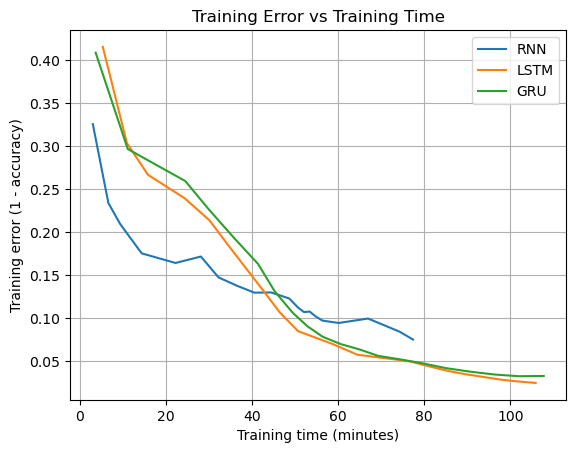

In [ ]:
# === Cell 9: Graph 1 — Training error (y) vs training time (x, minutes) ===
plt.figure()
for k, label in [('rnn','RNN'), ('lstm','LSTM'), ('gru','GRU')]:
    s = series[k]
    plt.plot(s['cum_time_min'], s['train_err'], label=label)
plt.xlabel('Training time (minutes)')
plt.ylabel('Training error')
plt.title('Training Error vs Training Time')
plt.grid(True); plt.legend(); plt.show()


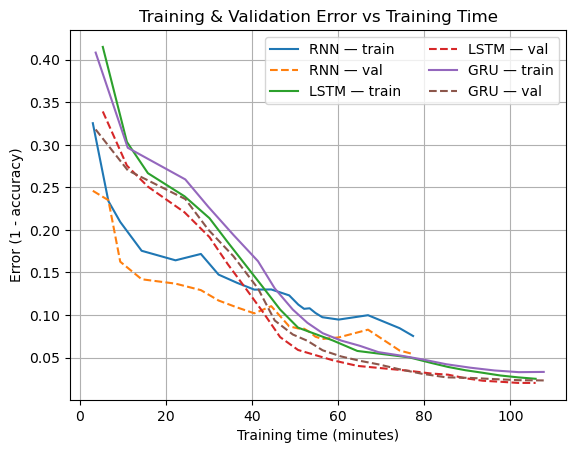

In [ ]:
# === Cell 10: Graph 2 — Training & Validation error vs training time (minutes) ===
plt.figure()
for k, label in [('rnn','RNN'), ('lstm','LSTM'), ('gru','GRU')]:
    s = series[k]
    plt.plot(s['cum_time_min'], s['train_err'], label=f'{label} — train')
    plt.plot(s['cum_time_min'], s['val_err'], linestyle='--', label=f'{label} — val')
plt.xlabel('Training time (minutes)')
plt.ylabel('Error (1 - accuracy)')
plt.title('Training & Validation Error vs Training Time')
plt.grid(True); plt.legend(ncol=2); plt.show()


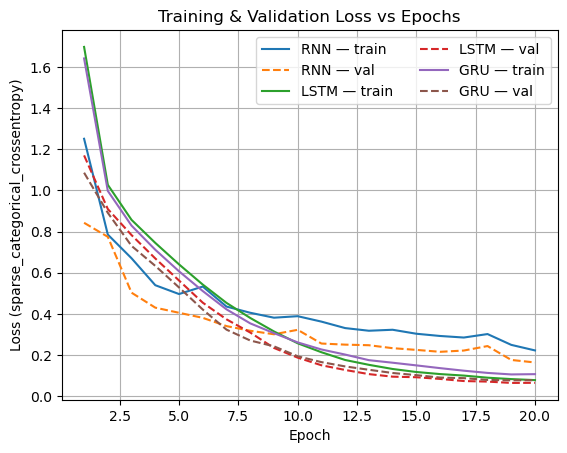

In [ ]:
# === Cell 11: Graph 3 — Loss (train & val) vs epochs ===
plt.figure()
for k, label in [('rnn','RNN'), ('lstm','LSTM'), ('gru','GRU')]:
    s = series[k]
    plt.plot(s['epochs'], s['train_loss'], label=f'{label} — train')
    plt.plot(s['epochs'], s['val_loss'], linestyle='--', label=f'{label} — val')
plt.xlabel('Epoch')
plt.ylabel('Loss (sparse_categorical_crossentropy)')
plt.title('Training & Validation Loss vs Epochs')
plt.grid(True); plt.legend(ncol=2); plt.show()


In [ ]:
# # === (Optional) Cell 12: 10 validation translations per model (for the report) ===
# id2fr = {idx: w for w, idx in french_tokenizer.word_index.items()}
# id2en = {idx: w for w, idx in english_tokenizer.word_index.items()}

# def decode_seq(seq, id2tok):
#     return ' '.join([id2tok.get(int(t), '') for t in seq if int(t) != 0])

# def predict_texts(model, X_in):
#     ids = model.predict(X_in, verbose=0).argmax(-1)   # (M, T_fr)
#     return [' '.join([id2fr.get(int(i), '') for i in row if int(i) != 0]) for row in ids]

# val_start = int((1 - VAL_SPLIT) * len(X))
# idxs = np.arange(val_start, min(val_start + 10, len(X))) if val_start < len(X) else np.arange(10)

# def show_10(model, name):
#     preds = predict_texts(model, X[idxs])
#     print(f"\n== {name} — {len(idxs)} validation examples ==")
#     for j, i in enumerate(idxs):
#         print(f"{j+1}. EN: {decode_seq(X[i], id2en)}")
#         print(f"   GT: {decode_seq(Y[i, :, 0], id2fr)}")
#         print(f"   PR: {preds[j]}\n")

# show_10(rnn_model,  "2x SimpleRNN")
# show_10(lstm_model, "2x LSTM")
# show_10(gru_model,  "2x GRU")



== 2x SimpleRNN — 10 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: california est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la poire est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet

- EN → the input sentence in English (what I fed to the encoder).

- GT → the Ground Truth target (the reference French sentence from the dataset).

- PR → the model’s Prediction (what the decoder generated after logits_to_text).

In [ ]:
# # === (Optional) Cell 12: 10 validation translations per model (for the report) ===
# id2fr = {idx: w for w, idx in french_tokenizer.word_index.items()}
# id2en = {idx: w for w, idx in english_tokenizer.word_index.items()}

# def decode_seq(seq, id2tok):
#     return ' '.join([id2tok.get(int(t), '') for t in seq if int(t) != 0])

# def predict_texts(model, X_in):
#     ids = model.predict(X_in, verbose=0).argmax(-1)   # (M, T_fr)
#     return [' '.join([id2fr.get(int(i), '') for i in row if int(i) != 0]) for row in ids]

# val_start = int((1 - VAL_SPLIT) * len(X))
# idxs = np.arange(val_start, min(val_start + 20, len(X))) if val_start < len(X) else np.arange(20)

# def show_20(model, name):
#     preds = predict_texts(model, X[idxs])
#     print(f"\n== {name} — {len(idxs)} validation examples ==")
#     for j, i in enumerate(idxs):
#         print(f"{j+1}. EN: {decode_seq(X[i], id2en)}")
#         print(f"   GT: {decode_seq(Y[i, :, 0], id2fr)}")
#         print(f"   PR: {preds[j]}\n")

# show_20(rnn_model,  "2x SimpleRNN")
# show_20(lstm_model, "2x LSTM")
# show_20(gru_model,  "2x GRU")



== 2x SimpleRNN — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: california est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la poire est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet

++++++++++++++++++++++++++++++++

In [ ]:
# === 20 validation translations per model — print ALL + save to files ===
import numpy as np
from IPython.display import Markdown, display
import os, logging, warnings

# (Optional) quiet TensorFlow/Autograph noise so your outputs are clean
try:
    import tensorflow as tf
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    tf.get_logger().setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=".*tf.function retracing.*")
except Exception:
    pass

# --- token id → word maps ---
id2fr = {idx: w for w, idx in french_tokenizer.word_index.items()}
id2en = {idx: w for w, idx in english_tokenizer.word_index.items()}

def decode_seq(seq, id2tok):
    return " ".join([id2tok.get(int(t), "") for t in seq if int(t) != 0])

def predict_texts(model, X_in):
    # (M, T_fr, V) -> (M, T_fr)
    ids = model.predict(X_in, verbose=0).argmax(-1)
    return [" ".join([id2fr.get(int(i), "") for i in row if int(i) != 0]) for row in ids]

# --- choose up to 20 validation indices ---
N = 20
val_start = int((1 - VAL_SPLIT) * len(X))
lo = val_start if val_start < len(X) else 0
hi = min(lo + N, len(X))
idxs = np.arange(lo, hi)

def format_block(model, name, idxs):
    preds = predict_texts(model, X[idxs])
    lines = [f"\n== {name} — {len(idxs)} validation examples =="]
    for j, i in enumerate(idxs):
        en = decode_seq(X[i], id2en)
        gt = decode_seq(Y[i, :, 0], id2fr)
        pr = preds[j]
        lines.append(f"{j+1}. EN: {en}\n   GT: {gt}\n   PR: {pr}\n")
    return "\n".join(lines)

# --- run all three models ---
blocks = []
for mdl, name in [(rnn_model, "2x SimpleRNN"),
                  (lstm_model, "2x LSTM"),
                  (gru_model,  "2x GRU")]:
    block = format_block(mdl, name, idxs)
    blocks.append(block)
    # print fully in notebook
    print(block, end="")  # end="" avoids extra blank lines
    # also save to a text file so you can open/download the complete output
    fname = name.lower().replace("×", "x").replace(" ", "_") + "_20_examples.txt"
    with open(fname, "w", encoding="utf-8") as f:
        f.write(block)
    # optionally render as a scrollable code block (nice in Jupyter/Colab)
    display(Markdown(f"```\n{block}\n```"))



print("\nSaved files: 2x_simplernn_20_examples.txt, 2x_lstm_20_examples.txt, 2x_gru_20_examples.txt, all_models_20_examples.txt")



== 2x SimpleRNN — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: california est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la poire est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet

```

== 2x SimpleRNN — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: california est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la poire est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet prochain
   PR: il envisage de se rendre en chine en juillet

6. EN: california is usually busy during april but it is usually chilly in august
   GT: californie est généralement occupé en avril mais il est généralement froid en août
   PR: californie est généralement froid en avril mais il est généralement froid en août

7. EN: he disliked a rusty black automobile
   GT: il n'aimait pas une voiture rouillée noir
   PR: il n'aimait pas une voiture rouillée rouillée

8. EN: india is nice during summer and it is beautiful in winter
   GT: l' inde est agréable en été et il est beau en hiver
   PR: l' inde est agréable en été et il est beau en hiver

9. EN: he likes grapes pears and oranges
   GT: il aime les raisins les poires et les oranges
   PR: il aime les raisins les poires et les oranges

10. EN: china is sometimes rainy during august and it is never snowy in february
   GT: chine est parfois pluvieux au mois d' août et il est jamais de neige en février
   PR: chine est parfois pluvieux au mois d' août et il est jamais de neige en février

11. EN: the cat was his most feared animal
   GT: le chat était son animal le plus redouté
   PR: le serpent était mon animal le plus redouté

12. EN: new jersey is usually cold during summer and it is sometimes dry in may
   GT: new jersey est généralement froid pendant l' été et il est parfois sèche en mai
   PR: new jersey est généralement froid pendant l' été et il est parfois sec en mai

13. EN: the orange is my least favorite fruit but the strawberry is their least favorite
   GT: l'orange est moins mon fruit préféré mais la fraise est leur moins préférée
   PR: l'orange est mon fruit préféré moins mais la poire est leur moins préférée

14. EN: france is hot during january but it is sometimes busy in march
   GT: france est chaud en janvier mais il est parfois occupé en mars
   PR: france est chaud en janvier mais il est parfois occupé en mars

15. EN: the united states is never beautiful during june but it is never pleasant in autumn
   GT: les états unis est jamais beau en juin mais il est jamais agréable à l' automne
   PR: les états unis est jamais humide en juin mais il est jamais agréable à l' automne

16. EN: the united states is wet during october but it is never busy in winter
   GT: les états unis est humide en octobre mais il est jamais trop de monde en hiver
   PR: les états unis est calme en octobre mais il est jamais trop en monde

17. EN: her most feared animal is the bear
   GT: son animal le plus redouté est l'ours
   PR: son animal le plus aimé est que ours

18. EN: she is driving the old blue car
   GT: elle conduit la vieille voiture bleue
   PR: elle conduit la vieille d' bleue

19. EN: india is sometimes busy during february and it is usually beautiful in may
   GT: l' inde est parfois occupé en février et il est généralement beau en mai
   PR: l' inde est parfois froid en février et il est généralement beau en mai

20. EN: new jersey is warm during june but it is sometimes rainy in autumn
   GT: new jersey est chaud en juin mais il est parfois pluvieux en automne
   PR: new jersey est chaud en juin mais il est parfois pluvieux à l' automne

```


== 2x LSTM — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la fraise est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet pro

```

== 2x LSTM — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la fraise est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet prochain
   PR: il envisage de visiter paris en juillet prochain

6. EN: california is usually busy during april but it is usually chilly in august
   GT: californie est généralement occupé en avril mais il est généralement froid en août
   PR: californie est généralement occupé en avril mais il est généralement froid en août

7. EN: he disliked a rusty black automobile
   GT: il n'aimait pas une voiture rouillée noir
   PR: il n'aimait pas une voiture noire brillante

8. EN: india is nice during summer and it is beautiful in winter
   GT: l' inde est agréable en été et il est beau en hiver
   PR: l' inde est agréable en été et il est beau en hiver

9. EN: he likes grapes pears and oranges
   GT: il aime les raisins les poires et les oranges
   PR: il aime les raisins les poires et les oranges

10. EN: china is sometimes rainy during august and it is never snowy in february
   GT: chine est parfois pluvieux au mois d' août et il est jamais de neige en février
   PR: chine est parfois pluvieux au mois d' août et il est jamais de neige en février

11. EN: the cat was his most feared animal
   GT: le chat était son animal le plus redouté
   PR: le chat était son animal le plus redouté

12. EN: new jersey is usually cold during summer and it is sometimes dry in may
   GT: new jersey est généralement froid pendant l' été et il est parfois sèche en mai
   PR: new jersey est généralement froid pendant l' été et il est parfois sèche en mai

13. EN: the orange is my least favorite fruit but the strawberry is their least favorite
   GT: l'orange est moins mon fruit préféré mais la fraise est leur moins préférée
   PR: l'orange est moins mon fruit préféré mais la fraise est leur moins préférée

14. EN: france is hot during january but it is sometimes busy in march
   GT: france est chaud en janvier mais il est parfois occupé en mars
   PR: france est chaud en janvier mais il est parfois occupé en mars

15. EN: the united states is never beautiful during june but it is never pleasant in autumn
   GT: les états unis est jamais beau en juin mais il est jamais agréable à l' automne
   PR: les états unis est jamais beau en juin mais il est jamais agréable à l' automne

16. EN: the united states is wet during october but it is never busy in winter
   GT: les états unis est humide en octobre mais il est jamais trop de monde en hiver
   PR: les états unis est humide en octobre mais il est jamais trop de monde en hiver

17. EN: her most feared animal is the bear
   GT: son animal le plus redouté est l'ours
   PR: son animal le plus redouté est l'oiseau

18. EN: she is driving the old blue car
   GT: elle conduit la vieille voiture bleue
   PR: elle conduit la vieille voiture bleue

19. EN: india is sometimes busy during february and it is usually beautiful in may
   GT: l' inde est parfois occupé en février et il est généralement beau en mai
   PR: l' inde est parfois occupé en février et il est généralement beau en mai

20. EN: new jersey is warm during june but it is sometimes rainy in autumn
   GT: new jersey est chaud en juin mais il est parfois pluvieux en automne
   PR: new jersey est chaud en juin mais il est parfois pluvieux en automne

```


== 2x GRU — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: californie est jamais froid pendant l' hiver mais il est jamais chaude en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la fraise est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet pro

```

== 2x GRU — 20 validation examples ==
1. EN: california is never chilly during winter but it is never warm in november
   GT: californie est jamais froid pendant l' hiver mais il est jamais chaud en novembre
   PR: californie est jamais froid pendant l' hiver mais il est jamais chaude en novembre

2. EN: my favorite fruit is the lemon but her favorite is the grapefruit
   GT: mon fruit préféré est le citron mais son préféré est le pamplemousse
   PR: mon fruit préféré est le citron mais son préféré est le pamplemousse

3. EN: the grape is their favorite fruit but the strawberry is our favorite
   GT: le raisin est leur fruit préféré mais la fraise est notre préféré
   PR: le raisin est leur fruit préféré mais la fraise est notre préféré

4. EN: she dislikes pears oranges and apples
   GT: elle déteste les poires les oranges et les pommes
   PR: elle déteste les poires les oranges et les pommes

5. EN: he plans to visit paris next july
   GT: il envisage de visiter paris en juillet prochain
   PR: il envisage de intention paris en juillet prochain

6. EN: california is usually busy during april but it is usually chilly in august
   GT: californie est généralement occupé en avril mais il est généralement froid en août
   PR: californie est généralement occupé en avril mais il est généralement froid en août

7. EN: he disliked a rusty black automobile
   GT: il n'aimait pas une voiture rouillée noir
   PR: il n'aimait pas une voiture noire noire

8. EN: india is nice during summer and it is beautiful in winter
   GT: l' inde est agréable en été et il est beau en hiver
   PR: l' inde est agréable en été et il est beau en hiver

9. EN: he likes grapes pears and oranges
   GT: il aime les raisins les poires et les oranges
   PR: il aime les raisins les poires et les oranges

10. EN: china is sometimes rainy during august and it is never snowy in february
   GT: chine est parfois pluvieux au mois d' août et il est jamais de neige en février
   PR: chine est parfois pluvieux au mois d' août et il est jamais de neige en février

11. EN: the cat was his most feared animal
   GT: le chat était son animal le plus redouté
   PR: le chat était son animal le plus redouté

12. EN: new jersey is usually cold during summer and it is sometimes dry in may
   GT: new jersey est généralement froid pendant l' été et il est parfois sèche en mai
   PR: new jersey est généralement froid pendant l' été et il est parfois sec en mai

13. EN: the orange is my least favorite fruit but the strawberry is their least favorite
   GT: l'orange est moins mon fruit préféré mais la fraise est leur moins préférée
   PR: l'orange est moins mon fruit préféré mais la fraise est leur moins préférée

14. EN: france is hot during january but it is sometimes busy in march
   GT: france est chaud en janvier mais il est parfois occupé en mars
   PR: france est chaud en janvier mais il est parfois occupé en mars

15. EN: the united states is never beautiful during june but it is never pleasant in autumn
   GT: les états unis est jamais beau en juin mais il est jamais agréable à l' automne
   PR: les états unis est jamais beau en juin mais il est jamais agréable à l' automne

16. EN: the united states is wet during october but it is never busy in winter
   GT: les états unis est humide en octobre mais il est jamais trop de monde en hiver
   PR: les états unis est humide en octobre mais il est jamais trop en monde hiver

17. EN: her most feared animal is the bear
   GT: son animal le plus redouté est l'ours
   PR: son animal le plus redouté est l'ours

18. EN: she is driving the old blue car
   GT: elle conduit la vieille voiture bleue
   PR: elle conduit la vieille voiture bleue

19. EN: india is sometimes busy during february and it is usually beautiful in may
   GT: l' inde est parfois occupé en février et il est généralement beau en mai
   PR: l' inde est parfois occupée en février et il est généralement beau en mai

20. EN: new jersey is warm during june but it is sometimes rainy in autumn
   GT: new jersey est chaud en juin mais il est parfois pluvieux en automne
   PR: new jersey est chaud en juin mais il est parfois pluvieux à l' automne

```


Saved files: 2x_simplernn_20_examples.txt, 2x_lstm_20_examples.txt, 2x_gru_20_examples.txt, all_models_20_examples.txt


In [ ]:
# === Cell 9: Plotting helpers (errors vs time, loss vs epochs) ===
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

MODEL_NAMES = {'rnn':'2×SimpleRNN', 'lstm':'2×LSTM', 'gru':'2×GRU'}

def plot_training_error_vs_time(series):
    plt.figure(figsize=(6.2,4.2))
    for key, s in series.items():
        if len(s['train_err']) == 0: 
            continue
        plt.plot(s['cum_time_min'], s['train_err'], label=MODEL_NAMES[key], linewidth=2)
    plt.xlabel('Cumulative training time (min)')
    plt.ylabel('Training error  (1 − accuracy)')
    plt.title('Training error vs training time')
    plt.grid(True, alpha=.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_train_and_val_error_vs_time(series):
    plt.figure(figsize=(7.6,5.0))
    for key, s in series.items():
        if len(s['train_err']) == 0: 
            continue
        # train
        plt.plot(s['cum_time_min'], s['train_err'],
                 linestyle='--', linewidth=1.8, label=f"{MODEL_NAMES[key]} — train")
        # "testing" here = validation split during training
        if len(s['val_err']):
            plt.plot(s['cum_time_min'], s['val_err'],
                     linewidth=2.2, label=f"{MODEL_NAMES[key]} — val")
    plt.xlabel('Cumulative training time (min)')
    plt.ylabel('Error  (1 − accuracy)')
    plt.title('Train & validation error vs training time')
    plt.grid(True, alpha=.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

def plot_loss_vs_epochs(series):
    plt.figure(figsize=(7.6,5.0))
    for key, s in series.items():
        # train loss
        plt.plot(s['epochs'], s['train_loss'], linestyle='--', linewidth=1.8,
                 label=f"{MODEL_NAMES[key]} — train loss")
        # val loss
        if len(s['val_loss']):
            plt.plot(s['epochs'], s['val_loss'], linewidth=2.2,
                     label=f"{MODEL_NAMES[key]} — val loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss (sparse CE)')
    plt.title('Loss vs epochs (train & validation)')
    plt.grid(True, alpha=.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

plot_training_error_vs_time(series)
plot_train_and_val_error_vs_time(series)
plot_loss_vs_epochs(series)


In [ ]:
# === Cell 10: Side-by-side model comparison summary ===
def summary_dataframe(series, models_dict):
    rows = []
    for key, s in series.items():
        # guard for missing validation (should exist because you used validation_split)
        val_err = np.array(s['val_err']) if len(s['val_err']) else np.array([np.nan])
        val_acc = 1.0 - val_err
        best_idx = int(np.nanargmax(val_acc)) if np.isfinite(val_acc).any() else len(s['epochs'])-1

        final_train_acc = 1.0 - float(s['train_err'][-1])
        final_val_acc   = float(val_acc[-1]) if np.isfinite(val_acc[-1]) else np.nan
        best_val_acc    = float(np.nanmax(val_acc))
        epochs_run      = int(len(s['epochs']))
        total_time_min  = float(s['cum_time_min'][-1])
        time_to_best    = float(s['cum_time_min'][best_idx]) if best_idx < len(s['cum_time_min']) else np.nan
        gen_gap         = float(final_train_acc - final_val_acc) if np.isfinite(final_val_acc) else np.nan
        params          = int(models_dict[key].count_params())

        rows.append({
            "Model": MODEL_NAMES[key],
            "Params": params,
            "Epochs": epochs_run,
            "Total time (min)": round(total_time_min, 2),
            "Final train acc": round(final_train_acc, 4),
            "Final val acc": round(final_val_acc, 4),
            "Best val acc": round(best_val_acc, 4),
            "Time to best (min)": round(time_to_best, 2),
            "Gen. gap (train−val)": round(gen_gap, 4),
        })
    df = pd.DataFrame(rows).sort_values("Best val acc", ascending=False).reset_index(drop=True)
    return df

models_dict = {'rnn': rnn_model, 'lstm': lstm_model, 'gru': gru_model}
comparison_df = summary_dataframe(series, models_dict)
comparison_df
